# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import time
import pickle
import gp_gpy as gp
import plot 
import GPy

LIKELIHOOD_MODEL = 'likelihood-v1'
PREDICTION_MODEL = 'predict-v1'
sns.set(style="darkgrid")
np.random.seed(1)
train = pd.read_pickle('train.pkl')
route_n = 3 # all data used currently is from route 3
n_segs = train.seg.unique()
train.head()

def synch_traj(synch_gp, data):
    X = data[['lat', 'lon']].values
    tau, _var = gp.predict(synch_gp, X)
    return data.assign(tau=tau.reshape(tau.shape[0]))

## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [47]:
def train_seg_gps(seg, route_n, traj_n, seg_n):
    synch_gp = gp.load_synch(route_n, seg_n)
    synched_seg = synch_traj(synch_gp, seg)
    n_restarts = 5
    print('training', route_n, traj_n, seg_n)
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg[['tau']], 
        synched_seg[['lat', 'lon']],
        LIKELIHOOD_MODEL,
        route_n, 
        traj_n, 
        seg_n)
    #likelihood_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.05))
    #likelihood_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.1))
    #ikelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.01, 0.005))
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg[['tau']], 
        synched_seg[['time_left']], 
        PREDICTION_MODEL, 
        route_n, 
        traj_n, 
        seg_n)    
    #prediction_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.05))
    #prediction_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.1))
    #prediction_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.01, 0.005))
    gp.train(prediction_model, n_restarts)

    return likelihood_model, prediction_model

t0 = time.time()
n_trajs = train.traj.unique()
for traj_n in n_trajs:
    traj = train[train.traj == traj_n
    n_segs = traj.seg.unique()
    for seg_n in n_seg:
        train_seg_gps(traj[traj.seg == seg_n], route_n, traj_n, seg_n)

dt = time.time() - t0
print("Data processed in", dt, " seconds")

training 3 2.0 2
Optimization restart 1/5, f = -208.16322825200595
Optimization restart 2/5, f = -208.16322887700642
Optimization restart 3/5, f = -208.16322888192843
Optimization restart 4/5, f = -208.34922916968063
Optimization restart 5/5, f = -208.34922917773383
Optimization restart 1/5, f = 11.853944274340261
Optimization restart 2/5, f = 11.853944274314951
Optimization restart 3/5, f = 11.853944274308002
Optimization restart 4/5, f = 11.853944274342606
Optimization restart 5/5, f = 11.853944274306816
training 3 2.0 3
Optimization restart 1/5, f = -293.1451390418607
Optimization restart 2/5, f = -293.14513903979446
Optimization restart 3/5, f = -293.14513904287105
Optimization restart 4/5, f = -293.14513904276225
Optimization restart 5/5, f = -293.1451390422027
Optimization restart 1/5, f = -25.878889886526444
Optimization restart 2/5, f = -25.87888988573253
Optimization restart 3/5, f = -25.878889897653664
Optimization restart 4/5, f = -25.87888989764935
Optimization restart 5/5,

KeyboardInterrupt: 

In [ ]:
# this guys crashed the thing if priors are set: traj 11, seg 9 | traj 8, seg 3 | 35.0 2
crash_data = train[(train.traj == 35) & (train.seg == 2)]
print(crash_data)
sns.scatterplot(data = crash_data, x='lat', y='lon', hue='progress')

Let's plot some of the likelihood GPs to see what they look like

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


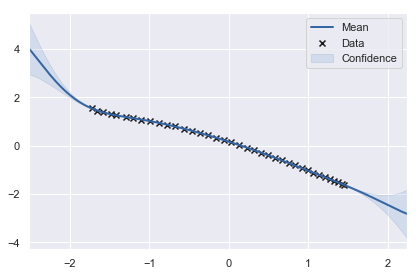

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


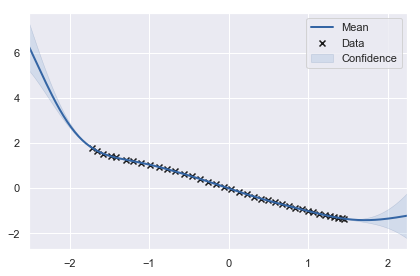

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


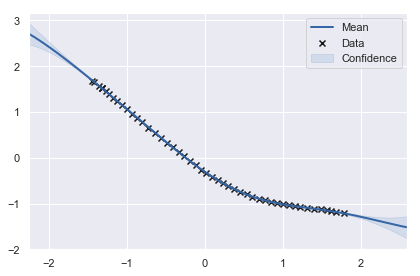

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


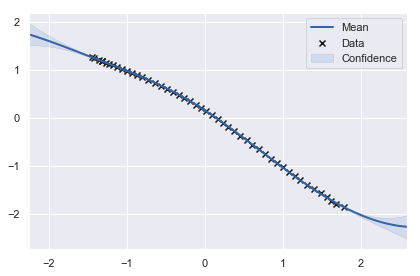

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


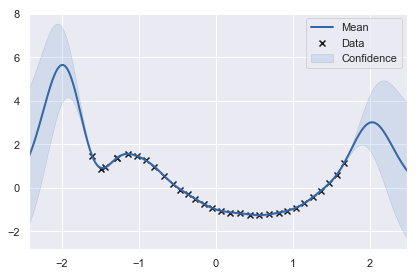

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


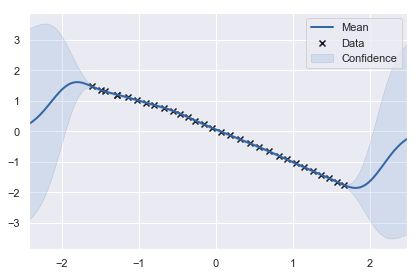

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


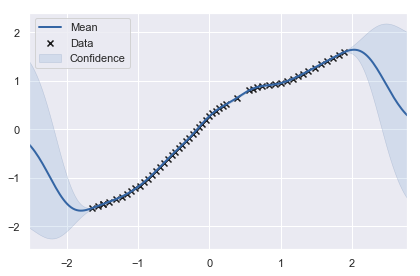

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


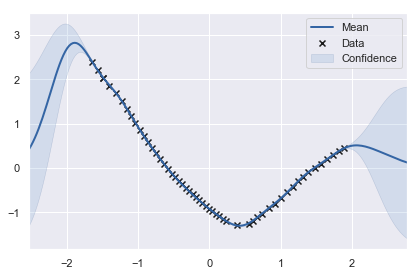

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


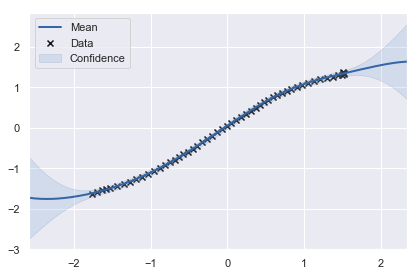

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


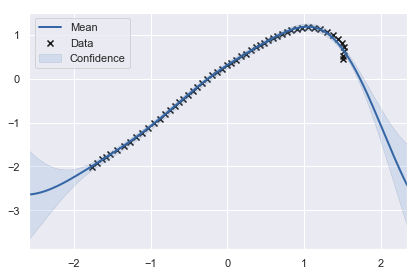

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


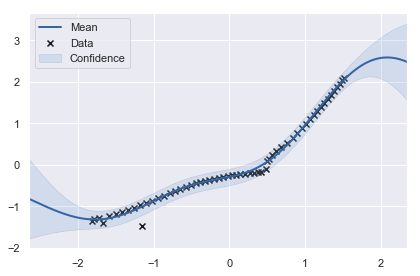

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


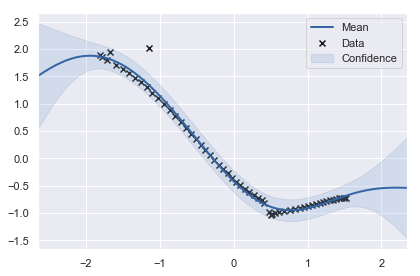

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


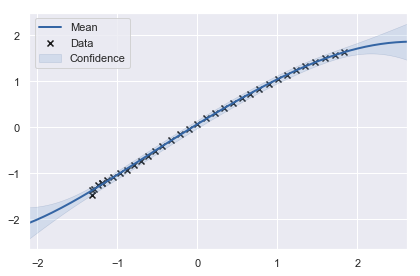

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


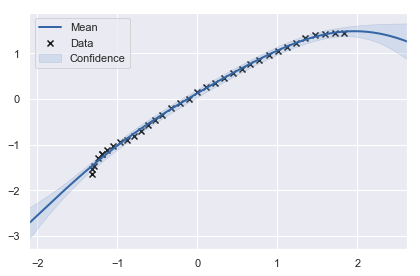

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


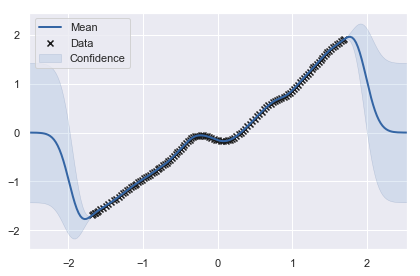

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


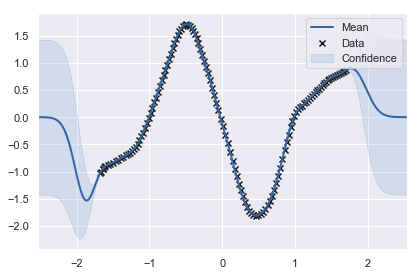

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


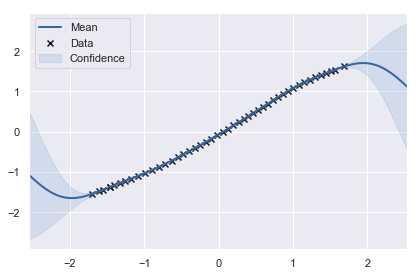

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


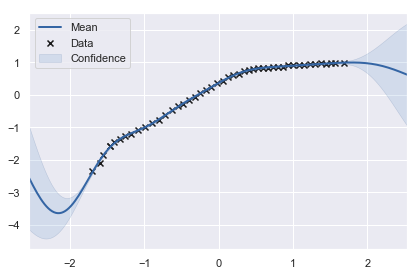

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


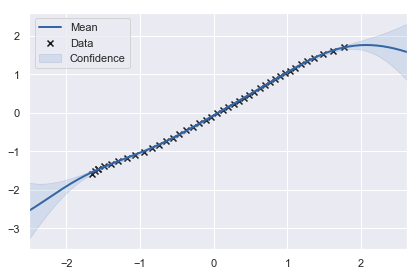

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


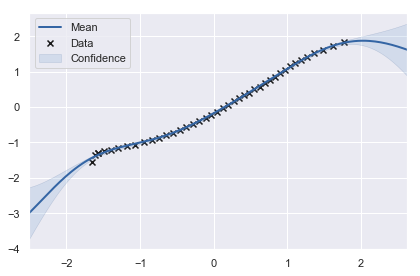

In [8]:
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    lik_model.model.plot(which_data_ycols=[0])
    lik_model.model.plot(which_data_ycols=[1])

Let's do the same for the predictive GP

In [67]:
import GPy
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    print(pred_model.route_n, pred_model.traj_n, pred_model.seg_n)
    pred_model.model.plot()

NameError: name 'traj_gps' is not defined

The results for both the GPs look really good. We'll save both to disk.

In [10]:
for models in traj_gps.values():
    for lik_model, pred_model in models.values():
        gp.save(lik_model)
        gp.save(pred_model)

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

[1022.7168810893313]
[(3, '139', 6)]
Most similair model 3 139 6
true model 3 2.0 6
           lat        lon  traj  seg  speed  time_left  progress
211  15.564052  58.408150   2.0    6   5.60       14.0  0.735849
212  15.564125  58.408165   2.0    6   5.24       13.0  0.754717
213  15.564207  58.408184   2.0    6   4.88       12.0  0.773585
214  15.564285  58.408195   2.0    6   4.73       11.0  0.792453
215  15.564365  58.408203   2.0    6   4.52       10.0  0.811321
pred: 44.18 true: 10.0 MAE: 34.18 MAPE: 3.42


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


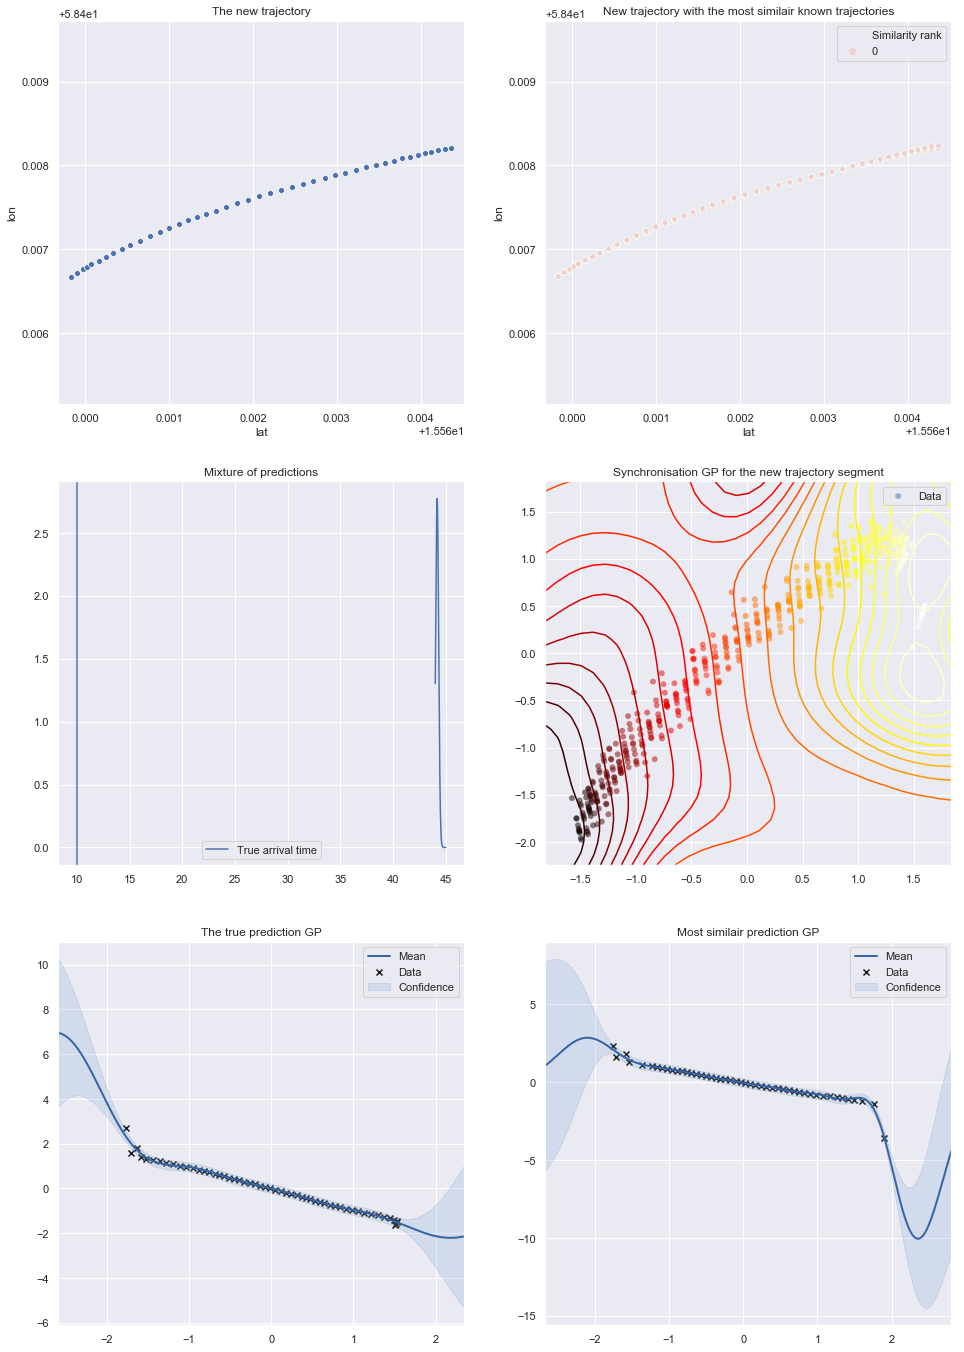

In [118]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

def plot_likelihood_models(models_by_loglik, synched_traj):
    X = synched_traj[['tau']].values
    def to_df(m, i):
        df = pd.DataFrame(gp.predict(m, X)[0], columns=['lat' ,'lon'])
        df['Similarity rank'] = i
        return df
    
    print([(m[0].route_n, m[0].traj_n, m[0].seg_n) for m in models_by_loglik])
    
    n_models = len(models_by_loglik)
    dfs = [to_df(mloglik[0], i) for mloglik, i in zip(models_by_loglik, range(n_models))]
    traj_df = synched_traj.copy()
    traj_df['Similarity rank'] = 0
    plt_df = pd.concat([traj_df] + dfs)
    
    sns.scatterplot(data=plt_df, x='lat', y='lon', hue='Similarity rank', ax=axs[0, 1])
    axs[0, 1].set_title('New trajectory with the most similair known trajectories')
    axs[0, 1].set_aspect('equal', 'datalim')    
    center_axs(axs[0, 1], synched_traj, ['lat', 'lon'])

    
def center_axs(ax, data, XY):
    ax.set_xlim(data[XY[0]].min()*0.99999, data[XY[0]].max()*1.00001)
    ax.set_ylim(data[XY[1]].min()*0.99999, data[XY[1]].max()*1.00001)
    
def mogp(traj, synch_gp, route_n, seg_n, plot):
    
    def data_loglik(model, X, Y):
        def loglik(x, y): 
            mu, sigma = gp.predict(model, x.reshape(1, 1))
            return -0.5*(y-mu)*np.linalg.inv(sigma)*(y-mu).T \
                    -0.5*np.log(np.abs(sigma))
        return np.sum([loglik(x, y) for x, y in zip(X, Y)])
        
    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(data.shape[0], 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(PREDICTION_MODEL, lik_model.route_n, lik_model.traj_n, lik_model.seg_n)
        
    def weighted_models(synched_traj, models):
        """
        Returns models and their weights, weighted by the posterior predictive probability of the model
        normalised over the maximum likelihood assuming uniform model prior. 
        So the most probable model has weight w = 1.0, and the less likely models has weights 0 < w < 1.0.
        """
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        n_models_to_use = 1
        models_with_loglik = [(m, data_loglik(m, X, Y)) for m in models]
        models_by_loglik = sorted(models_with_loglik, key=lambda mw: mw[1], reverse=True)[:n_models_to_use]
        print([m[1] for m in models_by_loglik])
        max_loglik = models_by_loglik[0][1]
        
        if plot:
            plot_likelihood_models(models_by_loglik, synched_traj)
            
        return [(m, np.exp(loglik - max_loglik)) for m, loglik in models_by_loglik]

    synched_traj = synch_traj(synch_gp, traj)
    lik_models = gp.load_trajs(LIKELIHOOD_MODEL, route_n, seg_n)
    lik_models_with_weights = weighted_models(synched_traj, lik_models)
    pred_models_with_weights = [(corresponding_pred_model(lik_m), w) for lik_m, w in lik_models_with_weights]
    print('Most similair model', lik_models_with_weights[0][0].route_n, lik_models_with_weights[0][0].traj_n, lik_models_with_weights[0][0].seg_n)
    
    if plot:
        pred_models_with_weights[0][0].model.plot(ax=axs[2, 1])
        axs[2, 1].set_title('Most similair prediction GP')
        
    latest_tau = synched_traj.iloc[-1][['tau']].values.reshape(1, 1)
    mean_var_weights = [gp.predict(m, latest_tau) + (w,) for m, w in pred_models_with_weights]
    return mean_var_weights

def predict(traj, synch_gp, route_n, seg_n, arrival_time=None, plot=False):
    mean_var_weights = mogp(traj, synch_gp, route_n, seg_n, plot)
    if plot:
        sort = sorted(mean_var_weights, key=lambda mvw: mvw[0])
        xmin = max(0, np.floor(float(sort[0][0]-sort[0][1]*3)))
        xmax = np.ceil(float(sort[-1][0]+sort[-1][1]*3))
        n = 200
        xx = np.linspace(xmin, xmax, n)
        yy = [] # use for mixture mode
        for mean, var, w in mean_var_weights:
            y = w*norm.pdf(xx, float(mean), np.sqrt(float(var)))
            yy.append(y)
            axs[1,0].plot(xx, y)
        axs[1,0].set_title('Mixture of predictions')
            
        if arrival_time:
            axs[1,0].axvline(x=arrival_time, label='True arrival time')
            axs[1,0].legend()
            
    models_by_similarity = sorted(mean_var_weights, key=lambda p: p[2], reverse=True)
    mode_model = int(np.ceil(np.argmax(yy)/n)-1)
    return float(mean_var_weights[mode_model][0])

#np.random.seed(8)
plot = True
if plot:
    fig, axs = plt.subplots(3,2)
    fig.set_figwidth(16)
    fig.set_figheight(24)
    
test = train # pd.read_pickle('test.pkl')
n_test_trajs = test.traj.unique()
traj_n = n_test_trajs[0]
test_traj = test[test.traj == traj_n]
seg_ix = 4
seg_n = test_traj.seg.unique()[seg_ix]
test_seg = test_traj[test_traj.seg == seg_n]
def predict_seg_with_plots(seg, route_n, traj_n, seg_n):
    i = test_seg.index[-1]-10 #np.random.randint(test_seg.index[0], test_seg.index[-1])
    seg = seg[seg.index <= i]
    synch_gp = gp.load_synch(route_n, seg_n)
    true = seg.iloc[-1].time_left
    pred = predict(seg, synch_gp, route_n, seg_n, true, plot=True)
    mae = float(np.abs(true-pred))
    mape = float(np.abs((true-pred)/true))
    print('true model', route_n, traj_n, seg_n)
    print(seg.tail())
    print('pred:', f"{pred:.2f}", 'true:', float(true), 'MAE:', f"{mae:.2f}", 'MAPE:', f"{mape:.2f}")
    
    sns.scatterplot(data=seg, x='lat', y='lon', ax=axs[0, 0])
    axs[0, 0].set_title('The new trajectory')
    axs[0, 0].set_aspect('equal', 'datalim')
    center_axs(axs[0, 0], seg, ['lat', 'lon'])
    
    synch_gp.model.plot(ax=axs[1,1])
    axs[1,1].set_title('Synchronisation GP for the new trajectory segment')
    pred_gp = gp.load(PREDICTION_MODEL, route_n, traj_n, seg_n)
    pred_gp.model.plot(ax=axs[2, 0])
    axs[2,0].set_title('The true prediction GP')
    
#print(test_seg[['lat', 'lon']])
predict_seg_with_plots(test_seg, route_n, traj_n, seg_n)

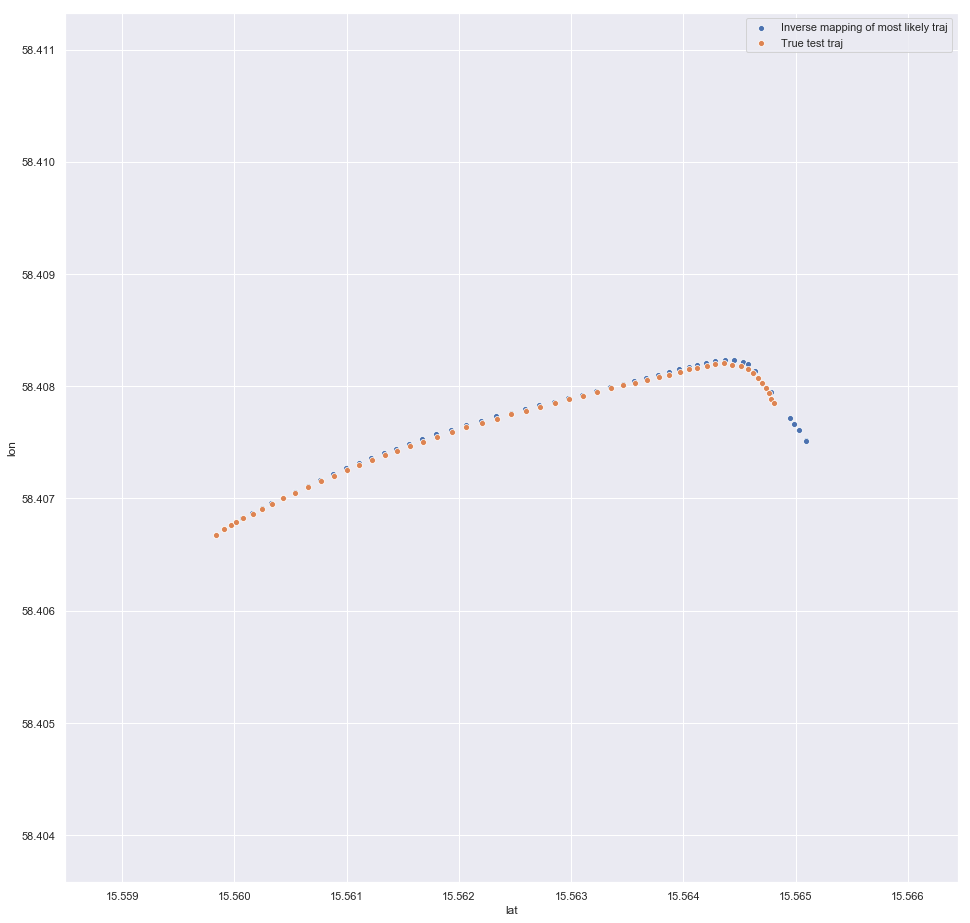

In [132]:
sgp = gp.load_synch(route_n, seg_n)
s_traj = synch_traj(sgp, test_seg)
m = gp.load(LIKELIHOOD_MODEL, 3, 139, seg_n)
df = pd.DataFrame(gp.predict(m, s_traj[['tau']].values)[0], columns=['lat' ,'lon'])
fig, ax = plt.subplots(1, 1)
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
ax.set_aspect('equal', 'datalim')
fig.set_figwidth(16)
fig.set_figheight(16)

54
47
72.0 104.0
57.0 94.0
53.0 91.0
50.0 86.0
49.0 82.0
48.0 81.0
47.0 80.0
46.0 79.0
45.0 78.0
44.0 77.0
43.0 76.0
42.0 75.0
41.0 74.0
40.0 73.0
39.0 72.0
38.0 71.0
37.0 70.0
36.0 69.0
35.0 68.0
34.0 67.0
33.0 66.0
32.0 65.0
31.0 64.0
30.0 63.0
29.0 62.0
28.0 61.0
27.0 60.0
26.0 59.0
25.0 58.0
24.0 57.0
23.0 56.0
22.0 55.0
21.0 54.0
20.0 53.0
19.0 52.0
18.0 51.0
17.0 50.0
16.0 49.0
15.0 48.0
14.0 47.0
13.0 46.0
12.0 45.0
11.0 44.0
10.0 43.0
9.0 42.0
8.0 39.0
7.0 0.0


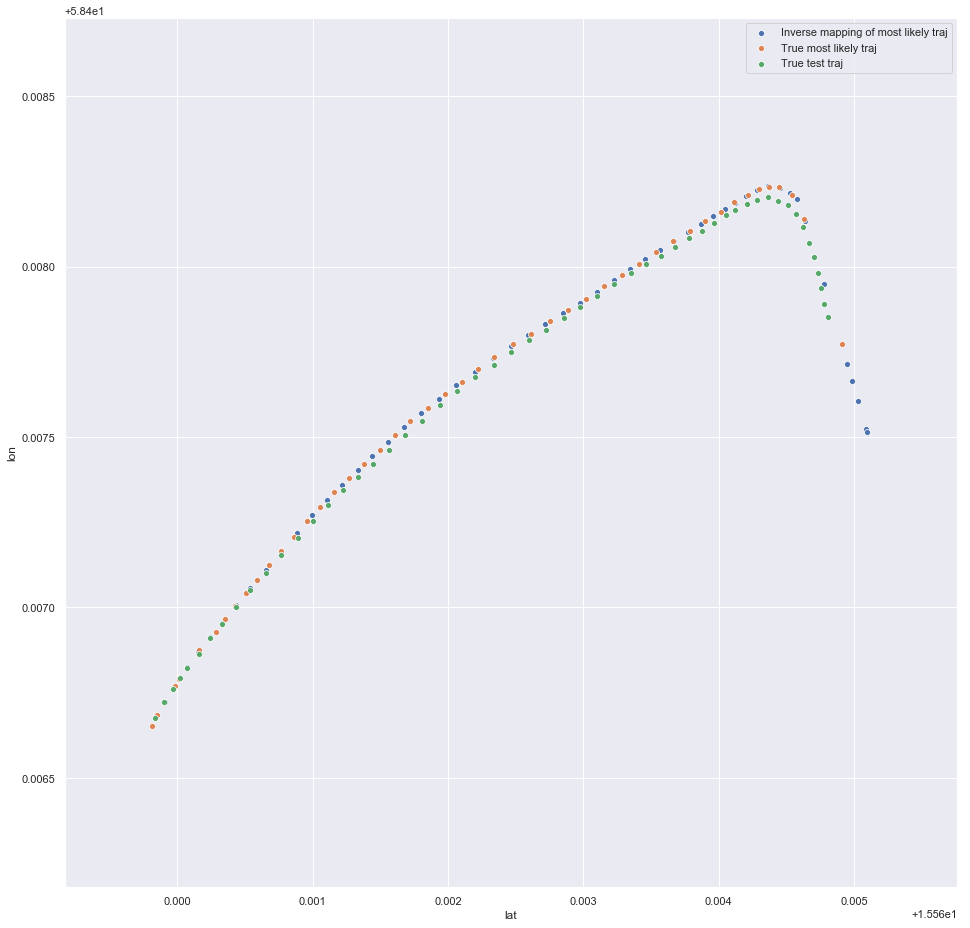

In [133]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(16)
fig.set_figheight(16)
most_likely_seg = train[(train.traj == 139) & (train.seg == seg_n)]
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=most_likely_seg, x='lat', y='lon', ax=ax, label='True most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
print(test_seg.shape[0])
print(most_likely_seg.shape[0])
for a, b in (zip(test_seg.time_left, most_likely_seg.time_left)):
    print(a, b)

Segments 1.0, 1.2, 1.4 are strange, does not seem to converge on one trajectory. Segment 4.2 has an 11 second jump at the final data point

In [ ]:
MAPE = []
MAE = []
for seg_n in test.seg.unique()[0:1]:
    seg = test[test.seg == seg_n]
    for traj_n in seg.traj.unique()[0:2]:
        traj = seg[seg.traj == traj_n]
        predict_seg(traj, route_n, seg_n, plot)
       

In [ ]:

abs_errs = []
for traj_n in n_test_trajs:
    traj = test[test.traj == traj_n]
    n_traj_segs = traj.seg.unique()
    for seg_n in n_traj_segs[0:1]:
        seg = traj[traj.seg == seg_n]
        i = np.random.randint(seg.index[0], seg.index[-1]-1)
        seg = seg[seg.index < i]
        synch_gp = gp.load_synch(route_n, seg_n)
        pred = predict(seg, synch_gp, route_n, seg_n)
        true = test_seg.iloc[-1].time_left
        abs_errs.append(np.abs((true-pred)/true))

mape = np.mean(abs_errs)
mape

In [ ]:
print(abs_errs)